<a href="https://colab.research.google.com/github/Erickrus/llm/blob/main/nanogpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# nanoGPT

<img alt="nanoGPT" src="https://github.com/karpathy/nanoGPT/blob/master/assets/nanogpt.jpg?raw=true" width="600px" />

The simplest, fastest repository for training/finetuning medium-sized GPTs. It is a rewrite of [minGPT](https://github.com/karpathy/minGPT) that prioritizes teeth over education. Still under active development, but currently the file `train.py` reproduces GPT-2 (124M) on OpenWebText, running on a single 8XA100 40GB node in 38 hours of training. The code itself is plain and readable: `train.py` is a ~300-line boilerplate training loop and `model.py` a ~300-line GPT model definition, which can optionally load the GPT-2 weights from OpenAI. That's it.

<img alt="repro124m" src="https://github.com/karpathy/nanoGPT/blob/master/assets/gpt2_124M_loss.png?raw=true" width="600px" />

Because the code is so simple, it is very easy to hack to your needs, train new models from scratch, or finetune pretrained checkpoints (e.g. biggest one currently available as a starting point would be the GPT-2 1.3B model from OpenAI).

Also check out:

https://www.youtube.com/watch?v=kCc8FmEb1nY

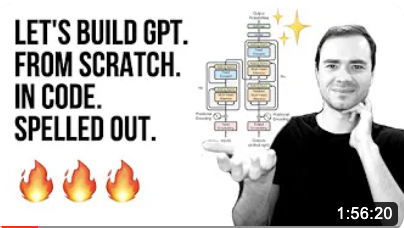

## Setup

In [ ]:
#@title Clone repository and Download dataset
#@markdown clone from https://github.com/karpathy/nanoGPT
!git clone https://github.com/karpathy/nanoGPT

# favorite toy dataset it's called tiny Shakespeare
#@markdown download from https://github.com/karpathy/char-rnn
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

Cloning into 'nanoGPT'...
remote: Enumerating objects: 495, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 495 (delta 1), reused 1 (delta 1), pack-reused 489
Receiving objects: 100% (495/495), 747.13 KiB | 2.12 MiB/s, done.
Resolving deltas: 100% (288/288), done.
--2023-02-13 05:27:50--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2023-02-13 05:27:51 (16.9 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
#@title ### install
#@markdown
#@markdown Dependencies:
#@markdown
#@markdown - [pytorch](https://pytorch.org) <3
#@markdown - [numpy](https://numpy.org/install/) <3
#@markdown - `pip install transformers` for huggingface transformers <3 (to load GPT-2 checkpoints)
!pip install transformers==4.26.0
#@markdown - `pip install datasets` for huggingface datasets <3 (if you want to download + preprocess OpenWebText)
#!pip install datasets for huggingface datasets <3 (if you want to download + preprocess OpenWebText)
#@markdown - `pip install tiktoken` for OpenAI's fast BPE code <3
!pip install tiktoke==0.1.2
#@markdown - `pip install wandb` for optional logging <3
!pip install wandb==0.13.9
#@markdown - `pip install tqdm`
!pip install tqdm==4.64.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 83.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tiktoke==0.1.2 (from versions: none)
ERROR: No matching distribution found for tiktoke==0.1.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 21.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
#@title Check out tiny-shakespeare dataset
with open('input.txt', 'r', encoding='utf-8') as f:
  text = f.read()
print("length of dataset in characters: ", len(text), "\n\n")
print(text[:1000])

length of dataset in characters:  1115394 


First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in h

In [ ]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [ ]:
# create a mapping from characters to integers
stoi = {ch:i for i, ch in enumerate(chars)}
itos = {i:ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: "".join([itos[i] for i in l]) # decoder: take a list of integers, otuput a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


Google uses a **SentencePiece**

SentencePiece is a sub word sort of tokenizer and what that means is that you're not encoding entire words but you're not also encoding individual characters. It's a sub word unit  level and that's usually what's adopted in practice.

https://github.com/google/sentencepiece

OpenAI uses a **TikToken**

Also openai has this Library called tiktoken that uses a pipe pair encoding tokenizer.

https://github.com/openai/tiktoken



In [ ]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earlier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [ ]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [ ]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [ ]:
# x are the inputs to the Transformer it  will just be the first block_size characters
x = train_data[:block_size]
# y will be the next block_size characters. So it's offset by one,
# and that's because y are the targets for each position in the input
# and then here I'm iterating over all the  block size of 8
y = train_data[1:block_size+1]
for t in range(block_size):
  context = x[:t+1]
  target = y[t]
  print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


the Transformer Network be used to seeing contexts all the way from as little as one all the way to block_size
and we'd like the transformer to be used to seeing everything in between

and that's going to be useful later during inference,  because while we're sampling we can start the sampling generation with as little as one character of context

and the Transformer knows how to predict the next character with all the way up to just one context of one

and so then it can predict everything up to block_size
and after block_size we have to start truncating because the Transformer will never receive more than block_size inputs when it's predicting the next character

In [ ]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data)- block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print("inputs:")
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('--------')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f"when input is {context.tolist()} the target: {target}")

# 18:49

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
--------
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44

In [ ]:
print(xb) # our input to the transformer

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        # B: Batch 4, T: Time 8, C: channel is lookup size which is vocab_size
        logits = self.token_embedding_table(idx) # logits (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T) # or targets.view(-1)
            # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
            # cross_entropy accepts (minibatch, C) vs (minibatch)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            #focus only on the last time step
            logits = logits[:, -1, :] # becomes (B,C) # we long lookup the -1 last one, this is not enough for modeling
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B,C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)
idx = torch.zeros((1,1), dtype=torch.long)
print(decode(m.generate(idx, max_new_tokens=100)[0].tolist()))

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)

SKIcLT;AcELMoTbvZv C?nq-QE33:CJqkOKH-q;:la!oiywkHjgChzbQ?u!3bLIgwevmyFJGUGp
wnYWmnxKWWev-tDqXErVKLgJ


In [ ]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [ ]:
batch_size = 32
for steps in range(10000):
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())


2.382369041442871


In [ ]:
print(decode(m.generate(torch.zeros((1,1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


lso br. ave aviasurf my, yxMPZI ivee iuedrd whar ksth y h bora s be hese, woweee; the! KI 'de, ulseecherd d o blllando;LUCEO, oraingofof win!
RIfans picspeserer hee tha,
TOFonk? me ain ckntoty ded. bo'llll st ta d:
ELIS me hurf lal y, ma dus pe athouo
BEY:! Indy; by s afreanoo adicererupa anse tecorro llaus a!
OLeneerithesinthengove fal amas trr
TI ar I t, mes, n IUSt my w, fredeeyove
THek' merer, dd
We ntem lud engitheso; cer ize helorowaginte the?
Thak orblyoruldvicee chot, p,
Bealivolde Th li


In [ ]:
%%writefile /content/nanoGPT/bigram_language_model_v1.py
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 32 # how many independent sequences will we process in parallel ?
block_size = 8 # what is the maximum context length for predictions ?
max_iters = 3000
eval_interval = 300
learning_rate = 1e-2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all teh unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = {ch:i for i, ch in enumerate(chars)}
itos = {i:ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: "".join([itos[i] for i in l]) # decoder: take a list of integers, otuput a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data)- block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        # B: Batch 4, T: Time 8, C: channel is lookup size which is vocab_size
        logits = self.token_embedding_table(idx) # logits (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T) # or targets.view(-1)
            # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
            # cross_entropy accepts (minibatch, C) vs (minibatch)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            #focus only on the last time step
            logits = logits[:, -1, :] # becomes (B,C) # we long lookup the -1 last one, this is not enough for modeling
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B,C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel(vocab_size)
m = model.to(device)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)

for iter in range(max_iters):
    # every once in a while evaluate the loss on the train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, ")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))


Writing /content/nanoGPT/bigram_language_model_v1.py


In [ ]:
!python /content/nanoGPT/bigram_language_model_v1.py

step 0: train loss 4.7305, val loss 4.7241, 
step 300: train loss 2.8110, val loss 2.8249, 
step 600: train loss 2.5434, val loss 2.5682, 
step 900: train loss 2.4932, val loss 2.5088, 
step 1200: train loss 2.4863, val loss 2.5035, 
step 1500: train loss 2.4665, val loss 2.4921, 
step 1800: train loss 2.4683, val loss 2.4936, 
step 2100: train loss 2.4696, val loss 2.4846, 
step 2400: train loss 2.4638, val loss 2.4879, 
step 2700: train loss 2.4738, val loss 2.4911, 

MARI he avayokis erceller thour d, myono thishe me tord se by he me, Forder anen: at trselorinjulour t yoru thrd wo ththathy IUShe bavidelanoby man ond be jus as g e atot Meste hrle s, ppat t JLENCOLIUS:
Oppid tes d s o ged moer y pevehear soue maramapay fo t: bueyo malalyo!
Duir.
Fl ke it I t l o'ddre d ondu s?
cr, havetrathackes w.
PUpee meshancun, hrendspouthoulouren whel's'sesoread pe, s whure our heredinsethes; sedsend r lo pamit,
QUMIVIVIOfe m ne RDINid we tr ort; t:
MINENXI l dintandore r



### The mathematical trick in self-attention

In [ ]:
# consider the following toy example:

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

# 42:25

torch.Size([4, 8, 2])

In [ ]:
#@title mean version 1
#@markdown We want $x[b,t] = mean_{i<=t} x[b,i]$
#bow bag of words
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C) everything upto and including t-th token
        xbow[b,t] = torch.mean(xprev, 0) # over the 0-dimension

In [ ]:
#@title mean version 2
#bow means 'bag of words'
wei = torch.tril(torch.ones(T,T))
# It is weighted aggregation, and the weights are specified in wei (T, T)
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # (T,T) @ (B,T,C) => pytorch will make it (B, T, T) @ (B, T, C) --> (B, T, C)
torch.allclose(xbow, xbow2)

True

In [ ]:
#@title The trick uses torch.tril
# torch has such function called tril, which is short for trianglar
# https://pytorch.org/docs/stable/generated/torch.tril.html
# lower triangular part
torch.tril(torch.ones(3, 3))

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [ ]:
xbow[0], xbow2[0]

(tensor([[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]]), tensor([[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]]))

In [ ]:
x[0]

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])

In [ ]:
xbow[0]

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

In [ ]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3,3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b # here we just use matrice multiplication, row multiply column and sum
# we can use multiply to do the average in an incremental fasion, that's very convenient
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [ ]:
tril = torch.tril(torch.ones(T,T))
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [ ]:
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril==0, float('-inf'))
wei

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
wei = F.softmax(wei, dim=-1)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [ ]:
#@title mean version 3: use Softmax
tril = torch.tril(torch.ones(T,T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril==0, float('-inf')) # the feature cannot communicte with future
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)

True

In [ ]:
%%writefile /content/nanoGPT/bigram_language_model_v2.py
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 32 # how many independent sequences will we process in parallel ?
block_size = 8 # what is the maximum context length for predictions ?
max_iters = 3000
eval_interval = 300
learning_rate = 1e-2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all teh unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = {ch:i for i, ch in enumerate(chars)}
itos = {i:ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: "".join([itos[i] for i in l]) # decoder: take a list of integers, otuput a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data)- block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        # idx and targets are both (B,T) tensor of integers
        # B: Batch 4, T: Time 8, C: channel is lookup size which is vocab_size
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C) -> (B,T,C)
        x = tok_emb + pos_emb # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T) # or targets.view(-1)
            # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
            # cross_entropy accepts (minibatch, C) vs (minibatch)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            #focus only on the last time step
            logits = logits[:, -1, :] # becomes (B,C) # we long lookup the -1 last one, this is not enough for modeling
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B,C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)

for iter in range(max_iters):
    # every once in a while evaluate the loss on the train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, ")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))


Writing /content/nanoGPT/bigram_language_model_v2.py


In [ ]:
!python /content/nanoGPT/bigram_language_model_v2.py

step 0: train loss 4.4801, val loss 4.4801, 
step 300: train loss 2.5404, val loss 2.5566, 
step 600: train loss 2.5160, val loss 2.5335, 
step 900: train loss 2.4967, val loss 2.5149, 
step 1200: train loss 2.5106, val loss 2.5254, 
step 1500: train loss 2.4853, val loss 2.5109, 
step 1800: train loss 2.4966, val loss 2.5198, 
step 2100: train loss 2.4949, val loss 2.5100, 
step 2400: train loss 2.4937, val loss 2.5102, 
step 2700: train loss 2.5040, val loss 2.5114, 
Traceback (most recent call last):
  File "/content/nanoGPT/bigram_language_model_v2.py", line 129, in <module>
    print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))
  File "/content/nanoGPT/bigram_language_model_v2.py", line 96, in generate
    logits, loss = self(idx)
  File "/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/content/nanoGPT/bigram_language_model_v2.py", line 76, in forward
    pos_emb = self.p